In [36]:
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
import typing as tp
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
nltk.download('averaged_perceptron_tagger_eng')

In [38]:
text_paths = [
    "books/Trainspotting (1993).txt",
    "books/Marabou Stork Nightmares (1995).txt",
    "books/Ecstasy (1996).txt"
]

In [39]:
def preprocess_text_pipeline(
    text: str,
    language: str = "english",
) -> list[str]:
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.replace('\n', ' ')
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(rf"[{string.punctuation}’—…]", '', text)
    text = text.strip()

    tokens = word_tokenize(text)
    stop_words = set(stopwords.words(language))
    tokens = [word for word in tokens if word not in stop_words]

    return tokens

In [40]:
def read_text(path: str) -> str:
    with open(path, 'r', encoding='utf-8') as f:
        text = f.read()

    return text

In [41]:
def form_gls(texts: tp.Sequence[str]) -> str:
    return "\n".join(texts)


In [42]:
def split_gls(
    tokens: tp.Sequence[str],
    segment_size: int,
    step: tp.Optional[int] = None,
) -> list[list[str]]:
    if step is None:
        step = segment_size

    segments = [
        tokens[i:i + segment_size]
        for i in range(0, len(tokens) - segment_size + 1, step)
    ]

    return segments

In [43]:
def compute_word_frequency(
    tokens: tp.Sequence[str],
    word: str,
    norming_factor: tp.Optional[int] = None,
) -> float:
    total_value = len(tokens)
    count_value = tokens.count(word)
    word_frequency = count_value / total_value

    if norming_factor is not None:
        word_frequency *= norming_factor

    return word_frequency

In [44]:
def get_frequency(
    segments: tp.Sequence[tp.Sequence[str]],
    words: tp.Sequence[str],
    norming_factor: tp.Optional[int] = None,
    round_value: tp.Optional[int] = None
) -> list[dict[str, tp.Any]]:
    return [
        {
            "segment": idx,
            "parameter": word,
            "frequency": round(compute_word_frequency(segment, word, norming_factor), round_value),
        }
        for idx, segment in enumerate(segments, start=1)
        for word in words
    ]

In [45]:
def plot_frequency(data: tp.Sequence[tp.Mapping[str, tp.Any]]) -> None:
    df = pd.DataFrame(data)

    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))
    ax = sns.lineplot(
        data=df,
        x="segment",
        y="frequency",
        hue="parameter",
        marker="o",
    )

    ax.set_title(f"Эволюция частоты употребления выбранных слов (на {norming_factor} слов)")
    ax.set_xlabel("Номер сегмента (ВЛС)")
    ax.set_ylabel("Относительная частота")
    plt.legend(title="Слово")

    plt.show()

In [46]:
def tag_tokens(tokens: tp.Sequence[str]) -> list[tuple[str, str]]:
    return pos_tag(tokens, tagset="universal")

In [47]:
def get_pos_distribution(tagged_tokens: tp.Sequence[tuple[str, str]]) -> list[dict[str, tp.Any]]:
    pos_counts: dict[str, int] = {}
    total_tokens = len(tagged_tokens)

    for _, pos in tagged_tokens:
        pos_counts[pos] = pos_counts.get(pos, 0) + 1

    result = [
        {
            "pos": pos,
            "count": count,
            "percentage": round((count / total_tokens) * 100, 2)
        }
        for pos, count in pos_counts.items()
    ]

    return result

In [48]:
def get_word_distribution(tagged_tokens: tp.Sequence[tuple[str, str]]) -> list[dict[str, tp.Any]]:
    pos_counts: dict[str, int] = {}
    word_pos_counts: dict[str, dict[str, int]] = {}

    for word, pos in tagged_tokens:
        pos_counts[pos] = pos_counts.get(pos, 0) + 1

        if pos not in word_pos_counts:
            word_pos_counts[pos] = {}
        word_pos_counts[pos][word] = word_pos_counts[pos].get(word, 0) + 1

    result = [
        {
            "word": word,
            "pos": pos,
            "count": count,
            "pos_total": pos_counts[pos],
            "ratio_in_pos": count / pos_counts[pos]
        }
        for pos, words_dict in word_pos_counts.items()
        for word, count in words_dict.items()
    ]

    return result


In [64]:
def plot_pos_distribution(
    data: tp.Sequence[tp.Mapping[str, tp.Any]],
    title: str = "Распределение частей речи",
) -> None:
    df = pd.DataFrame(data)

    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(x="pos", y="percentage", data=df, hue="pos", palette="Set2")

    ax.set_title(title)
    ax.set_xlabel("Часть речи")
    ax.set_ylabel("Процент от общего числа токенов (%)")
    plt.tight_layout()

    plt.savefig(f"{title}.png")

    plt.show()

In [65]:
def plot_word_distribution(
    data: tp.Sequence[dict[str, tp.Any]],
    top_n: int = 10,
) -> None:
    df = pd.DataFrame(data)
    df = df.sort_values("ratio_in_pos", ascending=False).head(top_n)

    title = f"Топ-{top_n} слов по доле в рамках своей POS"

    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x="word", y="ratio_in_pos", hue="pos", data=df, palette="Set1")
    plt.legend(title="Часть речи")

    ax.set_title(title)
    ax.set_xlabel("Слово")
    ax.set_ylabel("Доля в рамках POS")
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.savefig(f"{title}.png")

    plt.show()


In [52]:
words = [
    "fuckin",
    "man",
    "bad",
    "good",
]

In [53]:
segment_size = 1500
step = 1200

norming_factor = 10000

round_value = 2

In [54]:
gls_tokens = preprocess_text_pipeline(form_gls(list(map(read_text, text_paths))))

In [55]:
print("Общее количество токенов:", len(gls_tokens))

Общее количество токенов: 154409


In [56]:
segments = split_gls(gls_tokens, segment_size, step)

In [57]:
print("Количество сегментов:", len(segments))

Количество сегментов: 128


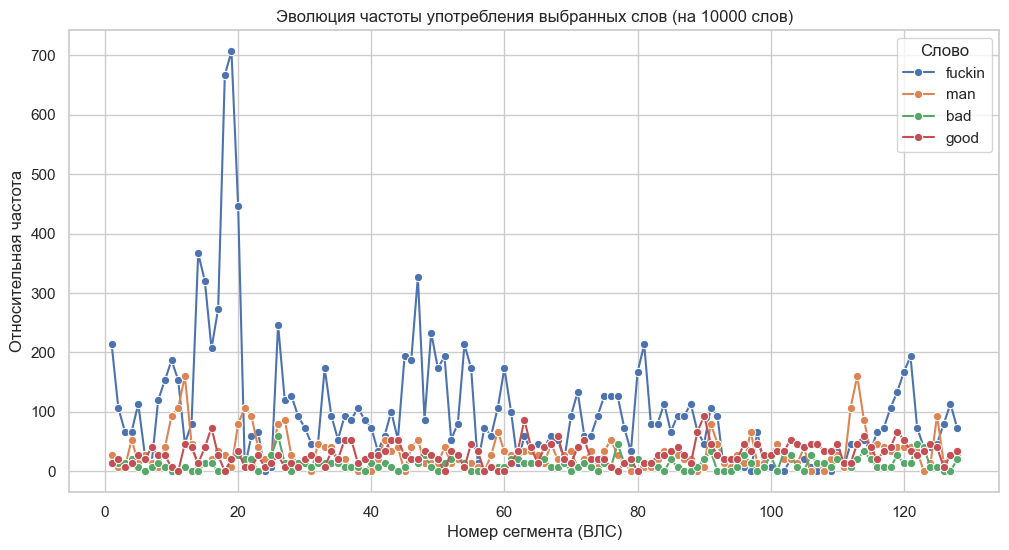

In [59]:
plot_frequency(get_frequency(segments, words, norming_factor, round_value))

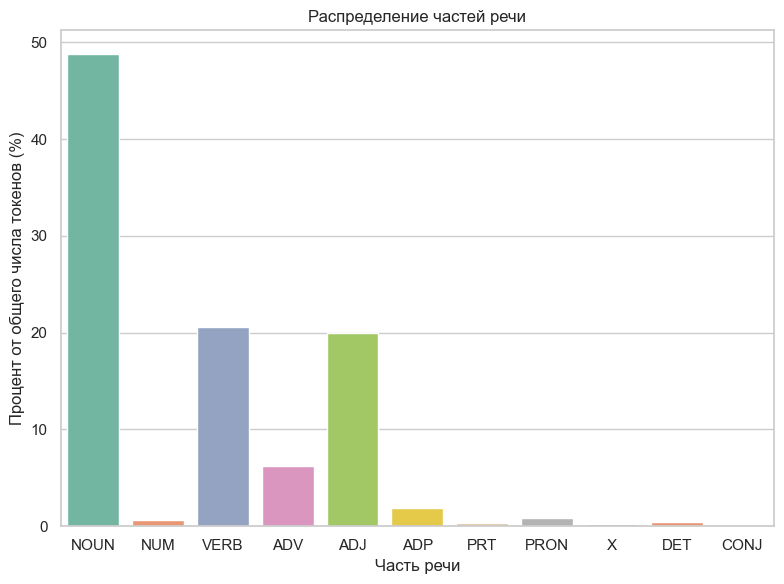

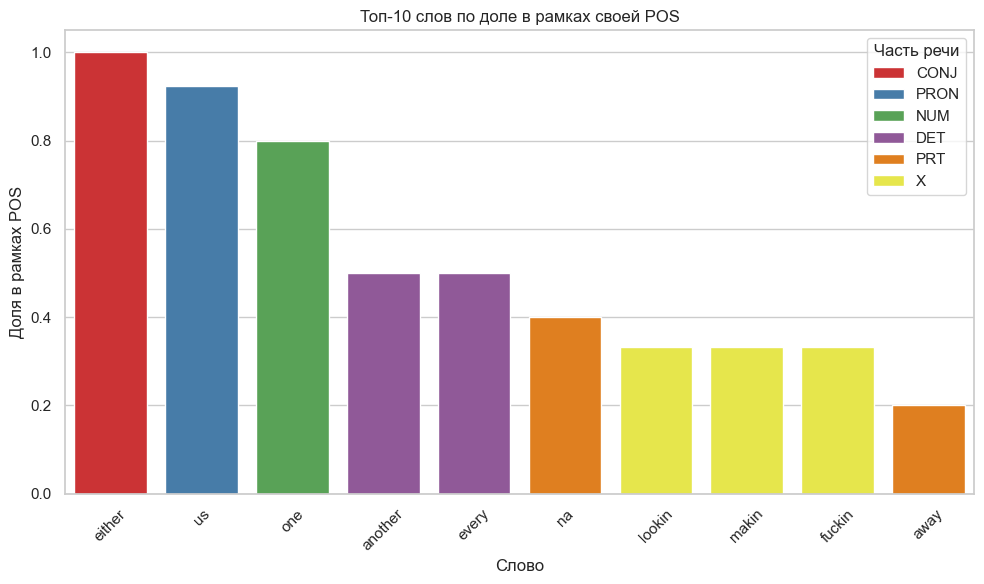

In [66]:
segment = segments[0]
tagged_tokens = tag_tokens(segment)
plot_pos_distribution(get_pos_distribution(tagged_tokens))
plot_word_distribution(get_word_distribution(tagged_tokens))

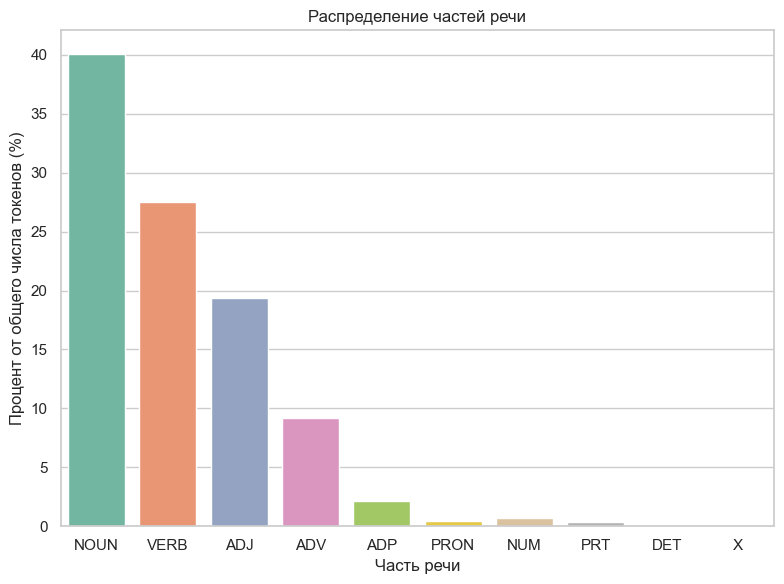

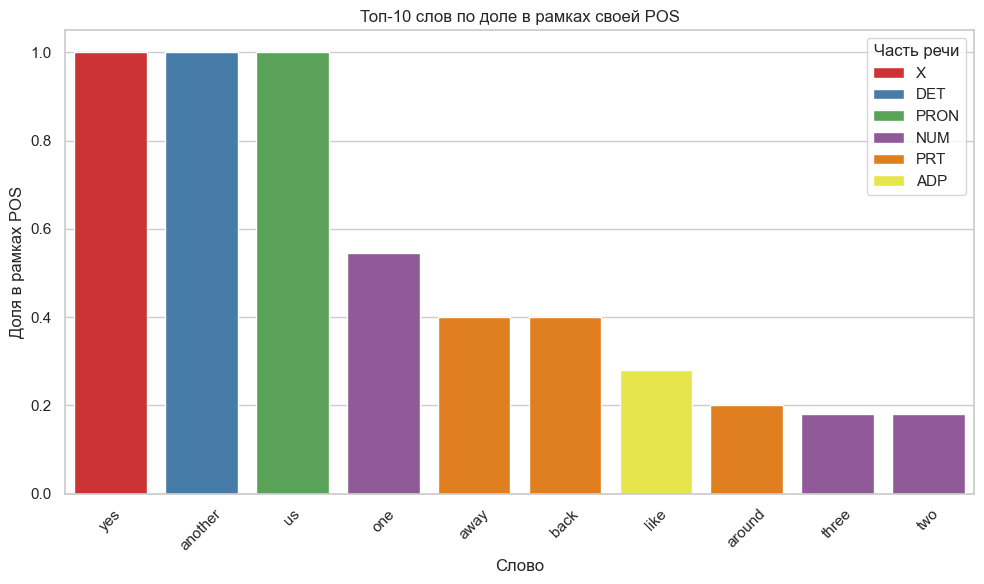

In [67]:
segment = segments[len(segments) // 2]
tagged_tokens = tag_tokens(segment)
plot_pos_distribution(get_pos_distribution(tagged_tokens))
plot_word_distribution(get_word_distribution(tagged_tokens))

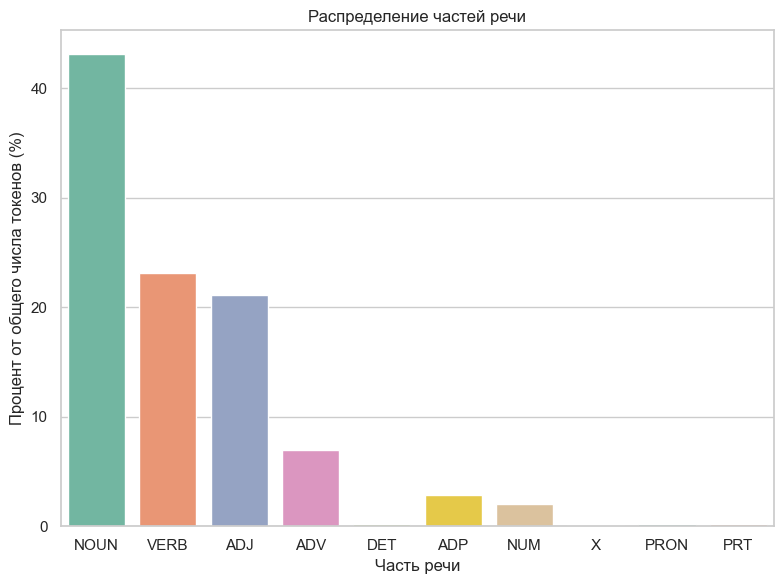

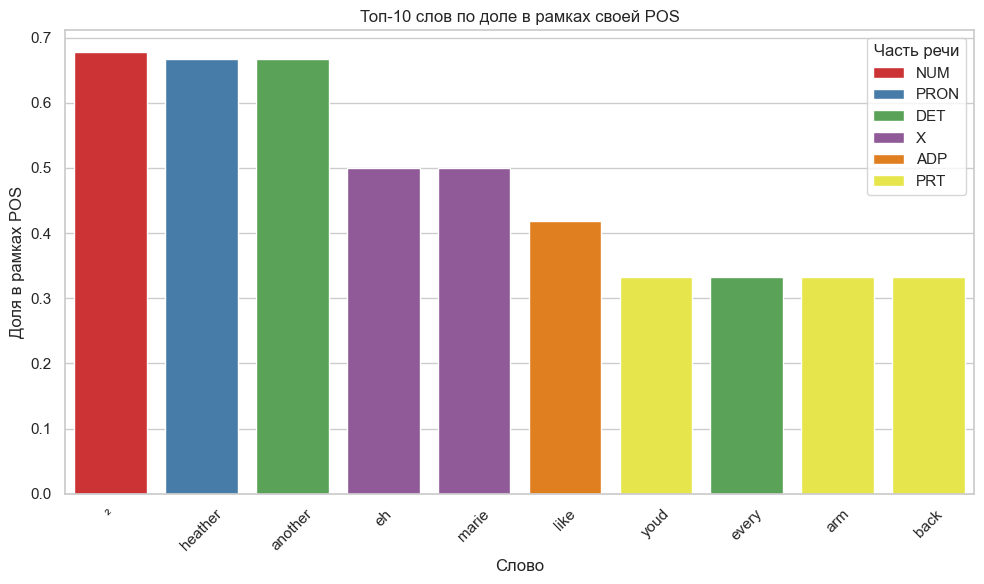

In [68]:
segment = segments[-1]
tagged_tokens = tag_tokens(segment)
plot_pos_distribution(get_pos_distribution(tagged_tokens))
plot_word_distribution(get_word_distribution(tagged_tokens))